In [1]:
using Flux
using Plots
using Parameters

import Random
using StatsBase # for random choice
Random.seed!(1234);

###### Data

In [2]:
in_features = 2
out_features = 1
N = 48

π_32 = Float32(π)
t = range(0.0f0,stop=3π_32, length = N)
sin_t = sin.(t)
cos_t = cos.(t)
data_x = reshape(hcat(sin_t, cos_t), (1, N, 2))
data_y = reshape(sin.(range(0.0f0,stop=6π_32, length = N)), (1, N, 1))#.astype(np.float32)
println(size(data_x))
println(size(data_y))
#dataloader = Flux.Data.DataLoader(data_x, data_y; batchsize=1, shuffle=true)

# Plots
#plot(data_x[:,:,1]')
#plot!(data_x[:,:,2]')
#plot!(data_y[1,:,1])

(1, 48, 2)
(1, 48, 1)


###### Wiring

In [3]:
# Macro for inserting fields 
macro def(name, definition) 
  return quote
      macro $(esc(name))()
          esc($(Expr(:quote, definition)))
      end
  end
end

# Wiring
# Do we really need the exact code as one for the biology?
abstract type Wiring end
@def wiring_fields begin
     units
     adjacency_matrix
     sensory_adjacency_matrix
     input_dim
     output_dim
end

# Outer constructor
#Wiring(units::Int64) = Wiring(units, zeros((units, units)), Nothing, Nothing)

# Methods
function _build(wiring::Wiring, input_shape) # for Wiring type
    _input_dim = convert(Int, input_shape[2])
    # do assert check
    if wiring.input_dim === nothing
        set_input_dim(wiring, _input_dim)
    end
end

function add_synapse(adjacency_matrix, src, dest, polarity)
    adjacency_matrix[src, dest] = polarity
    #adjacency_matrix
end

function _init_add_synapse(units, adjacency_matrix, self_conn)
    for src in (1:units)
        for dest in (1:units)
            if src === dest && !self_conn
                continue
            end
            polarity = StatsBase.sample([-1,1,1])
            add_synapse(adjacency_matrix, src, dest, polarity)
            #println(src, dest)
        end
    end
    #@show adjacency_matrix
end

function add_sensory_synapse(sensory_adjacency_matrix, src, dest, polarity)
    sensory_adjacency_matrix[src, dest] = polarity
    #adjacency_matrix
end

# not used?
function set_input_dim(wiring::Wiring, _input_dim)
    wiring.input_dim = _input_dim
    units = wiring.units
    wiring.sensory_adjacency_matrix = zeros((_input_dim, units))
end 

function _erev_initializer(wiring::Wiring, shape=nothing, dtype=nothing) # dtype?
    copy(wiring.adjacency_matrix)
end

function _sensory_erev_initializer(wiring::Wiring, shape=nothing, dtype=nothing) # dtype?
    copy(wiring.sensory_adjacency_matrix)
end

function _state_size(wiring::Wiring)
    return wiring.units
end

function _sensory_size(wiring::Wiring)
    return wiring.input_dim
end

function _motor_size(wiring::Wiring)
    return wiring.output_dim
end

# Test 
#set_input_dim(wiring, 2)

_motor_size (generic function with 1 method)

###### Fully Connected

In [4]:
mutable struct FullyConnected <: Wiring
    @wiring_fields
    self_conns # default value ?
    # Inner constructor
    function FullyConnected(units, _output_dim = nothing, _input_dim = nothing, self_conns = true) #arguments order and call?
        adjacency_matrix = zeros((units, units))
        sensory_adjacency_matrix = nothing
        if _output_dim === nothing
            output_dim = units
        else
            output_dim = _output_dim
        end
        _init_add_synapse(units, adjacency_matrix, self_conns)
        return new(units, adjacency_matrix, sensory_adjacency_matrix, _input_dim,
                   output_dim, self_conns)
    end
end

In [5]:
# Methods
function build(wiring::FullyConnected, input_shape)
    _build(wiring, input_shape) # from Wiring
    #@show wiring
    input_dim = wiring.input_dim
    units = wiring.input_dim
    sensory_adjacency_matrix = wiring.sensory_adjacency_matrix
    for src in (1:input_dim)
        for dest in (1:units)
#             if src === dest && !self_conn
#                 continue
#             end
            polarity = StatsBase.sample([-1,1,1])
            @show polarity
            add_sensory_synapse(sensory_adjacency_matrix, src, dest, polarity)
            #println(src, dest)
        end
    end
end

build (generic function with 1 method)

In [6]:
function _get_init_ranges()
    _init_ranges = Dict(
            "gleak"=> (0.001, 1.0),
            "vleak"=> (-0.2, 0.2),
            "cm"=> (0.4, 0.6),
            "w"=> (0.001, 1.0),
            "sigma"=> (3, 8),
            "mu"=> (0.3, 0.8),
            "sensory_w"=> (0.001, 1.0),
            "sensory_sigma"=> (3, 8),
            "sensory_mu"=> (0.3, 0.8))
end

_get_init_ranges (generic function with 1 method)

In [7]:
# For initializing fields
function _get_init_value(shape, name, init_ranges)
    minval, maxval = init_ranges[name]
    if minval === maxval
        return ones(shape) * minval
    else
        return rand(Float64, shape) * (maxval - minval) .+ minval
    end
end

_get_init_value (generic function with 1 method)

In [8]:
function _get_mapping_weights(wiring, input_mapping, output_mapping,
                              input_w, input_b, output_w, output_b)
    sensory_size = _sensory_size(wiring)
    motor_size = _motor_size(wiring)
    
    if input_mapping in ["affine", "linear"]
        input_w = ones((1, sensory_size))
    end
    if input_mapping in ["affine"]
        input_b = zeros((1, sensory_size))
    end
    if output_mapping in ["affine", "linear"]
        output_w = ones(motor_size)
    end
    if output_mapping in ["affine"]
        output_b = zeros(motor_size)
    end
    return input_w, input_b, output_w, output_b
end

_get_mapping_weights (generic function with 1 method)

### LTC cell

###### Definition


In [9]:
# Weights fields 
@def trainable_weights begin
    gleak
    vleak
    cm
    sigma
    mu
    w
    sensory_sigma
    sensory_mu
    sensory_w
    #erev
    #sensory_erev
    # conditional
    input_w
    input_b
    output_w
    output_b
    # 13 weights in total
end

@trainable_weights (macro with 1 method)

In [10]:
mutable struct LTCCell
    _wiring::Wiring        
    #_init_ranges
    _input_mapping::String
    _output_mapping::String
    _ode_unfolds::Int
    _epsilon
    #_params::Dict # Is this trainable in Dict format?
    state0 # for Recur
    sparsity_mask
    sensory_sparsity_mask
    erev
    sensory_erev
    @trainable_weights
    
    function LTCCell(wiring, in_features = nothing, input_mapping="affine",
            output_mapping="affine", ode_unfolds=6, epsilon=1e-8, state0=zeros(1, 8), 
            input_w = nothing, input_b = nothing, output_w = nothing,  output_b = nothing)
        
        if in_features !== nothing
            build(wiring, (nothing, in_features))
        end
        
        state_size = _state_size(wiring)
        sensory_size = _sensory_size(wiring)
        motor_size = _motor_size(wiring)
        # Is this proper place?
        init_ranges = _get_init_ranges()
        input_w, input_b, output_w, output_b = _get_mapping_weights(wiring, input_mapping,
                                            output_mapping,
                                            input_w, input_b, output_w, output_b)
        new(wiring, 
            input_mapping,
            output_mapping,
            ode_unfolds,
            epsilon,
            state0,
            abs.(wiring.adjacency_matrix),
            abs.(wiring.sensory_adjacency_matrix),
            _erev_initializer(wiring),
            _sensory_erev_initializer(wiring), 
            _get_init_value(state_size, "gleak", init_ranges), 
            _get_init_value(state_size, "vleak", init_ranges),
            _get_init_value(state_size, "cm", init_ranges),
            _get_init_value((state_size, state_size), "sigma", init_ranges),
            _get_init_value((state_size, state_size), "mu", init_ranges),
            _get_init_value((state_size, state_size), "w", init_ranges),
            _get_init_value((sensory_size, state_size), "sensory_sigma", init_ranges),
            _get_init_value((sensory_size, state_size), "sensory_mu", init_ranges),
            _get_init_value((sensory_size, state_size), "sensory_w", init_ranges),
            input_w,
            input_b,
            output_w,
            output_b)
    end
end

In [11]:
#wiring = FullyConnected(8)
#cell = LTCCell(wiring, in_features)

In [12]:
# Additional
function _state_size(ltc::LTCCell)
    return _state_size(ltc._wiring)
end

_state_size (generic function with 2 methods)

In [13]:
function apply_weight_constraints(LTC)
    LTC.cell.w = Flux.relu.(LTC.cell.w)
    LTC.cell.sensory_w = Flux.relu.(LTC.cell.sensory_w)
    LTC.cell.cm = Flux.relu.(LTC.cell.cm)
    LTC.cell.gleak = Flux.relu.(LTC.cell.gleak)
end

apply_weight_constraints (generic function with 1 method)

### ODE

In [14]:
function _map_inputs(ltc::LTCCell, inputs)
    if ltc._input_mapping in ["affine", "linear"]
        inputs = inputs .* ltc.input_w # Element-wise 
        #@show ltc.input_b
    end
    if ltc._input_mapping === "affine"

        inputs = inputs .+ ltc.input_b
    end
    
    @assert size(inputs) === (1,2)
    return inputs
end

function _map_outputs(ltc::LTCCell, state)
    output = state
    _motor_size = ltc._wiring.output_dim
    #@show _motor_size, _state_size(ltc)
    if _motor_size < _state_size(ltc)
        println("!oups")
        output = output[:, 1:_motor_size]  # slice
    end
    if ltc._output_mapping in ["affine", "linear"]
        output = output .* reshape(ltc.output_w, (1, size(ltc.output_w)...)) # Element-wise 
    end
    if ltc._output_mapping === "affine"
        output = output .+ reshape(ltc.output_b, (1, size(ltc.output_b)...)) # Element-wise 
    end
    #@assert size(inputs) === (1,2)
    return output    
end

_map_outputs (generic function with 1 method)

In [15]:
function _sigmoid(v_pre, mu, sigma)
    v_pre = reshape(v_pre, (size(v_pre)...,1)) # add batch dim
    mu = reshape(mu, 1, size(mu)...) # for dims match ?
    
    mues = v_pre .- mu 
  
    x = map(x_ -> (sigma .* x_), eachslice(mues, dims=1))[end]
    x = reshape(x, 1, size(x)...) # for dims match
    return σ.(x)
end

_sigmoid (generic function with 1 method)

In [16]:
function complicated_prod(a, b; dim=1)
    # This is for keeping some dim restriction during broadcasting
    out = map(x -> a .* x, eachslice(b, dims=dim))[end]
    reshape(out, 1, size(out)...) # for dims match ?
end

complicated_prod (generic function with 1 method)

In [17]:
function _ode_solver_(ltc::LTCCell, inputs, state, elapsed_time)
    v_pre = state
    # We can pre-compute the effects of the sensory neurons here
    println("Again we need slice(((")
    sensory_w_activation = complicated_prod(ltc.sensory_w,
                                            _sigmoid(inputs, ltc.sensory_mu,
                                                     ltc.sensory_sigma))    
    #@show size(sensory_w_activation)
    #@show size(ltc.sensory_sparsity_mask)
    sensory_w_activation =  complicated_prod(ltc.sensory_sparsity_mask, 
                                             sensory_w_activation,)
    
    sensory_rev_activation = complicated_prod(ltc.sensory_erev, sensory_w_activation)

    # Reduce over dimension 1 (=source sensory neurons)
    w_numerator_sensory = dropdims(sum(sensory_rev_activation, dims=2), dims=2)
    w_denominator_sensory =  dropdims(sum(sensory_w_activation, dims=2), dims=2)


    # cm/t is loop invariant
    cm_t = ltc.cm / (elapsed_time / ltc._ode_unfolds)
    # Unfold the multiply ODE multiple times into one RNN step
    for t = 1:ltc._ode_unfolds
        w_activation =  complicated_prod(ltc.w, 
                                        _sigmoid(
                                                v_pre, ltc.mu,
                                        ltc.sigma))
        w_activation = complicated_prod(ltc.sparsity_mask, w_activation) 

        rev_activation = complicated_prod(ltc.erev, w_activation)
        # Reduce over dimension 1 (=source neurons)
        w_numerator = dropdims(sum(rev_activation, dims=2), dims=2) .+ w_numerator_sensory
        #w_numerator = sum(rev_activation, dim=2) + w_numerator_sensory
        #w_denominator = sum(w_activation, dim=2) + w_denominator_sensory
        w_denominator = dropdims(sum(w_activation, dims=2), dims=2) .+ w_denominator_sensory        
 
        numerator = (
            reshape(cm_t, (1, size(cm_t)...)) .* v_pre 
            .+ reshape(ltc.gleak, (1, size(ltc.gleak)...))  
            .* reshape(ltc.vleak, (1, size(ltc.vleak)...))
            .+ w_numerator
        )
        denominator = reshape(cm_t, (1, size(cm_t)...)) 
             .+ reshape(ltc.gleak, (1, size(ltc.gleak)...))  
             .+ w_denominator
        # Avoid dividing by 0
        v_pre = numerator ./ (denominator .+ ltc._epsilon)
        #@show size(v_pre)
    end
    return v_pre
end

_ode_solver_ (generic function with 1 method)

### Forward

In [18]:
function (ltc::LTCCell)(state, inputs) # order matters !
    elapsed_time = 1.0f0
    inputs = _map_inputs(ltc, inputs)
    next_state = _ode_solver_(ltc, inputs, state, elapsed_time)
    outputs = _map_outputs(ltc, next_state)
    return next_state, outputs # for Recur the order matter
end

In [19]:
#wiring = FullyConnected(8, out_features)
#LTC = Flux.Recur(LTCCell(wiring, in_features), rand(1,8)) # toy state
#cell = LTCCell(wiring, in_features);
#forward_step(data_x)

###### Recur

In [20]:
wiring = FullyConnected(8, out_features)
LTC = Flux.Recur(LTCCell(wiring, in_features), zeros(size(data_x)[1], # batch size
                                              _state_size(wiring))); # 
#LTC(rand(1,2))

polarity = 1
polarity = -1
polarity = -1
polarity = -1


In [21]:
batch_size = size(data_x)[1] # batch dim
seq_len = size(data_x)[2]

48

In [22]:
function forward_step(x) 
    outputs = vcat([LTC(x[:, t, :])[end] for t in 1:seq_len]) # `end`
                                                              # for extracting number from array
    #@show outputs
    @show Flux.reset!(LTC)
    return reshape(outputs, (1, seq_len, 1))#. # for Recur
end

forward_step (generic function with 1 method)

In [23]:
# Test
#forward_step(data_x) 

# Loss

In [24]:
# do we need reset function?

In [25]:
loss(x, y) = sum(abs2.(forward_step(x) .- y))

loss (generic function with 1 method)

In [26]:
loss(data_x, data_y)

Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need 

1365.1938469801705

### grad

In [27]:
Flux.trainable(ltc::LTCCell) = (ltc.gleak,
                                ltc.vleak,
                                ltc.cm,
                                ltc.sigma,
                                ltc.mu,
                                ltc.w,
                                ltc.sensory_sigma,
                                ltc.sensory_mu,
                                ltc.sensory_w,
                                ltc.input_w,
                                ltc.input_b,
                                ltc.output_w,
                                ltc.output_b, ) 

There is definitely problem in forward step wrapper!!!

In [28]:
@show length(params(LTC))

grads = Flux.gradient(params(LTC)) do
     @show loss(data_x, data_y)#loss(data_x, data_y)
end

length(params(LTC)) = 13
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slic

Grads(...)

In [29]:
for p in grads
    println(p)
end

[726.4934499043114, -614.0606340433292, -63.990126138511215, 345.7111829966068, -38.24589181202607, -44.63609356332123, 9.938735082920022, -19.102787060421292]
[2830.3423350559656, -859.3105182896973, -817.5233569552208, 1448.8292131046226, -145.6748973919427, -190.9602883723055, -16.02646119303347, -11.898361343380815]
[-3538.533668680031, 266.72138386608503, 453.5307590532344, 73.82116861489203, 362.6400749385477, 4.1237536546084375, 131.40818836535314, 102.08229858944688]
[-119.58131037481145 20.85363210464338 12.703703636572708 2.034992302532026 8.775685029096438 -8.515683432646878 0.5852160926133113 6.319414449725505; 8.295446423147625 8.570875849389601 -4.311905198399916 5.442366657727874 5.9791009511705555 0.40774650882710556 0.1025475747575394 0.6607971676962945; 2.245709515985186 0.10642737895944776 5.740478662309194 11.917595507993815 2.777572709286531 3.2010114335006503 -0.3386936092483798 0.31649024281640137; -8.71427373543743 -4.997298771326038 -6.084523346832303 -9.376109

In [134]:
#opt = Flux.ADAM()
#ps = Flux.params(LTC)
#Flux.Optimise.update!(opt, ps, grads)

### Training 

In [30]:
ps = Flux.params(LTC)

Params([[0.3734729720015798, 0.2638579609056035, 0.9887018041539819, 0.4903685483259179, 0.4257860662107646, 0.38038523769239585, 0.28766801561709426, 0.11896739387226656], [0.09586319807143717, 0.1885520813751425, 0.0773888019503427, 0.11700888511408003, 0.11178705538779926, 0.08891330864897445, -0.1783959767918323, 0.19100183014188366], [0.5780368747823073, 0.5668148707727318, 0.4152898116948849, 0.44351697843176724, 0.43342694742003823, 0.4521293449266846, 0.4075253979742589, 0.5194033904332084], [3.267623866929129 6.4508961095774175 … 3.7622758756686165 4.177353312403776; 4.807545377219743 6.242160101284214 … 3.5391954074632066 5.8604902322702666; … ; 3.6840595216906142 5.1444454093802126 … 6.925972110231944 7.888924375685006; 6.315425657566083 5.6468205045352144 … 4.796993254526409 3.5901187637344796], [0.570080236974082 0.4129408079904198 … 0.434898923623856 0.3440127146745782; 0.6485399389275857 0.4265162363240174 … 0.7511337276283023 0.6951249045728083; … ; 0.5506673657901531 0

In [36]:
# use the ADAM optimizer. It's a pretty good one!
opt = Flux.ADAM(0.01) # 0.01 is autors' lr 

ADAM(0.01, (0.9, 0.999), IdDict{Any,Any}())

In [50]:
# callback = function (;doplot=false) #callback function to observe training
#   #pred = predict_n_ode()
#   display(loss(x, y))
#   # plot current prediction against data
#   #pl = scatter(t,y,label="data")
#   scatter!(pl,t, LTC(x) ,label="prediction")
#   #display(plot(pl))
#   return false
# end

In [53]:
#callback() = println("Loss NCP-LTC = $(loss(data, target,))")
x = data_x
y = data_y
epochs = 4
for epoch in 1:epochs
    gs = Flux.gradient(ps) do
        @show loss(x, y)
    end
    #@show epoch
    #@show Flux.Optimise.update!(opt, ps, gs)
    # clip some weights
    apply_weight_constraints(LTC)
    #@show ps
    if epoch % 100 == 1
        callback()
    end
end
#callback()

Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need 

12.736230963794522

Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need 

Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need slice(((
!oups
Again we need 

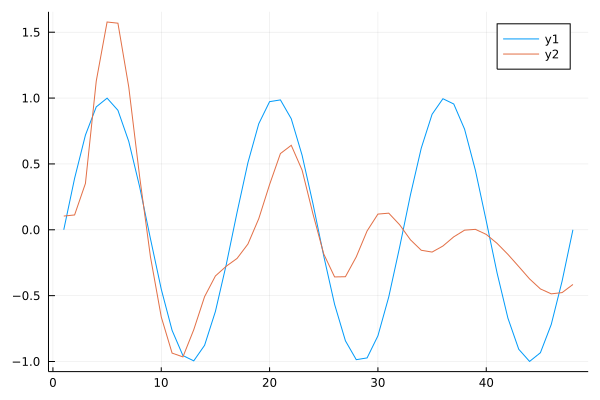

In [54]:
plot(data_y[1,:,1])
plot!(forward_step(data_x)[1,:,1])

Too long and not good

In [208]:
# evalcb() = @show(sum(loss.(data_x, data_y)))
# num_epochs = 10
# Flux.@epochs num_epochs Flux.train!(loss, ps, zip(data_x, data_y), opt, cb = Flux.throttle(evalcb, 1))

add train! and other methods for this



# Grad test

In [113]:
wiring = FullyConnected(8, out_features)
LTC = Flux.Recur(LTCCell(wiring, in_features), zeros(size(data_x)[1], # batch size
                                              _state_size(LTC.cell))) # 
LTC(rand(1,2))

wiring = FullyConnected(8, [1.0 1.0 1.0 1.0 1.0 -1.0 -1.0 -1.0; 1.0 1.0 -1.0 -1.0 1.0 -1.0 1.0 1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0; -1.0 -1.0 1.0 -1.0 1.0 -1.0 1.0 1.0; -1.0 -1.0 1.0 -1.0 -1.0 -1.0 -1.0 1.0; 1.0 1.0 1.0 1.0 1.0 -1.0 1.0 -1.0; -1.0 1.0 -1.0 -1.0 1.0 1.0 1.0 -1.0; 1.0 1.0 1.0 1.0 1.0 1.0 1.0 -1.0], [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0], 2, 1, true)
polarity = 1
polarity = -1
polarity = -1
polarity = -1
ltc.input_b = [0.0 0.0]
Again we need slice(((
!oups


1×1 Array{Float64,2}:
 -1.0885846182183796

In [114]:
@show length(params(LTC))

grads = Flux.gradient(params(LTC)) do
     @show sum(LTC(data_x))
end

length(params(LTC)) = 13


LoadError: [91mDimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 48 and 2")[39m

In [128]:
grads[LTC]

Base.RefValue{Any}((cell = nothing, state = nothing))

In [132]:
for p in enumerate(grads)
    println()
    println(p)
end


(1, [0.29516186789572274, 0.5102270913001762, -0.4764293434276783, -0.922456562849922, 0.31002696376815153, -0.48741672169563743, -0.34467060888225043, -0.512348306074301])

(2, [1.5045818704998288, 4.501890604818127, 4.209117020261336, 8.628970250040084, 1.2843096972497414, 0.5989526306795684, 1.7413484756085784, 2.234991267898473])

(3, [-0.6786236361222011, -7.3945211284622046, -9.47946168174181, -8.978544735233715, -4.337086626493717, 0.2610642419859756, 1.5663169021136614, 4.036367514804417])

(4, [-0.0690618890384682 0.16161270934362923 0.03027241810714818 -0.19973217810448307 0.010836742445836376 0.059633755776105205 -0.001322002508484603 0.01327172668108079; 0.0006456444862434857 0.007143057875587326 -0.06783855989026166 -0.06250666232303326 0.011480856054956596 -0.00022023053035800412 -0.005068535725237981 -0.004361181930809421; -0.0110111805597884 0.009431752641555888 -0.09307523943856895 -0.11392678914338858 -0.0206602349408851 -0.05334901427701315 -0.014224689386895376 0.0

In [134]:
# Traing